# Foreword
The code relies on three folders, that will be created in the working directory if they don't already exist:
- **trained**: All trained models will be saved in this folder
- **learning_rates**: The result of trying different learning rates will be saved here. 
- **temp**: Temporary folder whose contents can be deleted whenever the code is not running.

Throughout this notebook, many networks will be trained with various parameters, which can take a very long time. Rather than running all tests locally, you can download the **trained** and **learning_rates** folders from __[here](https://drive.google.com/file/d/1kmCMwFbVPqJc2PI2TGb-vzj11W0ltHl9/view?usp=sharing)__. Simply unzip the contents in the current folder and everything should work. The **temp** folder will be created automatically so don't worry about it.

# Outline
In this notebook we will create a convolutional neural network that can classify dog breeds. We will not be using transfer learning. The goal here is not to go as deep as possible or outperform the state of the art, but rather to understand the influence of various types of data augmentation and potential improvements, and therefore maximize the performance of a given architecture.

We will proceed as follows:
0. [Initialization](#step_0): Initialize everything, set parameters that won't change.
1. [Vanilla classification](#step_1): Initial classification with a standard architecture roughly based on VGG: 3 sets of 2 conv layers each, with each set followed by maxpooling. Finish with one fully connected layer with dropout and then output. We will also determine an appropriate learning rate here.
2. [Data augmentation](#step_2): Explore the different data augmentation techniques.
3. [Adding complexity](#step_3): Can we improve performance by adding another fully connected layer at the end?
4. [Reducing complexity](#step_4): What if we go the other way and instead of adding complexity (another layer) we simplify the model by replacing fully connected layers with global average pooling?
5. [Weight initialization](#step_5): How much would weight initialization help?
6. [Batch normalization](#step_6): Would batch normalization help? At the very least it should help us train faster. 
7. [Residual connections](#step_7): Can residual connections help our relatively shallow architecture?
8. [Testing](#step_8): Check the network's performance against the test set.
9. [Conclusions](#step_9): What have we learned from all this and what else can be done?

<a id="step_0"></a>
# Step 0: Initialization

Most functions and classes are in **misc.py** for the sake of brevity.

In [1]:
# Import most things
# We will use the normalization of ImageNet models from misc.py which has norm_mean and norm_std
from misc import *

%load_ext autoreload
%autoreload 2
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# We will need a folder to save the trained models in
if not os.path.isdir("./trained/"):
    os.mkdir("./trained/")
# We will also need a temp folder
if not os.path.isdir("./temp/"):
    os.mkdir("./temp/")
    
# Set some stuff that won't change
image_folder = (os.getcwd() + "/dogImages/").replace('\\','/')
n_epochs = 100
batch_size = 64
depth_1 = 32 # depth of the first filter stack; it gets doubled after each maxpool
fc_size = 512 # size of the fully connected layer
p_dropout = 0.5 # probability of dropout
num_workers = 8 
img_short_side_resize = 256
img_input_size = 224

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")
    print("Using",torch.cuda.get_device_name(device))

CUDA is available!  Training on GPU ...
Using GeForce RTX 2070


<a id="step_1"></a>
# Step 1: Basic classification

### Network architecture
The architecture we will be using is inspired by the popular __[VGG](https://arxiv.org/abs/1409.1556)__ networks. Here we use a simplified version, with three sets of two convolutional layers each, followed by max pooling. The initial depth of 32 is doubled after each set. The output of the third conv set (size 128 x 56 x 56) is flattened, dropout is applied, and is then sent to a fully connected layer with 512 neurons. After another round of dropout we send the result to the 133 neuron (number of dog breeds) output layer.

We directly output class scores and use __[nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#crossentropyloss)__ as our criterion.

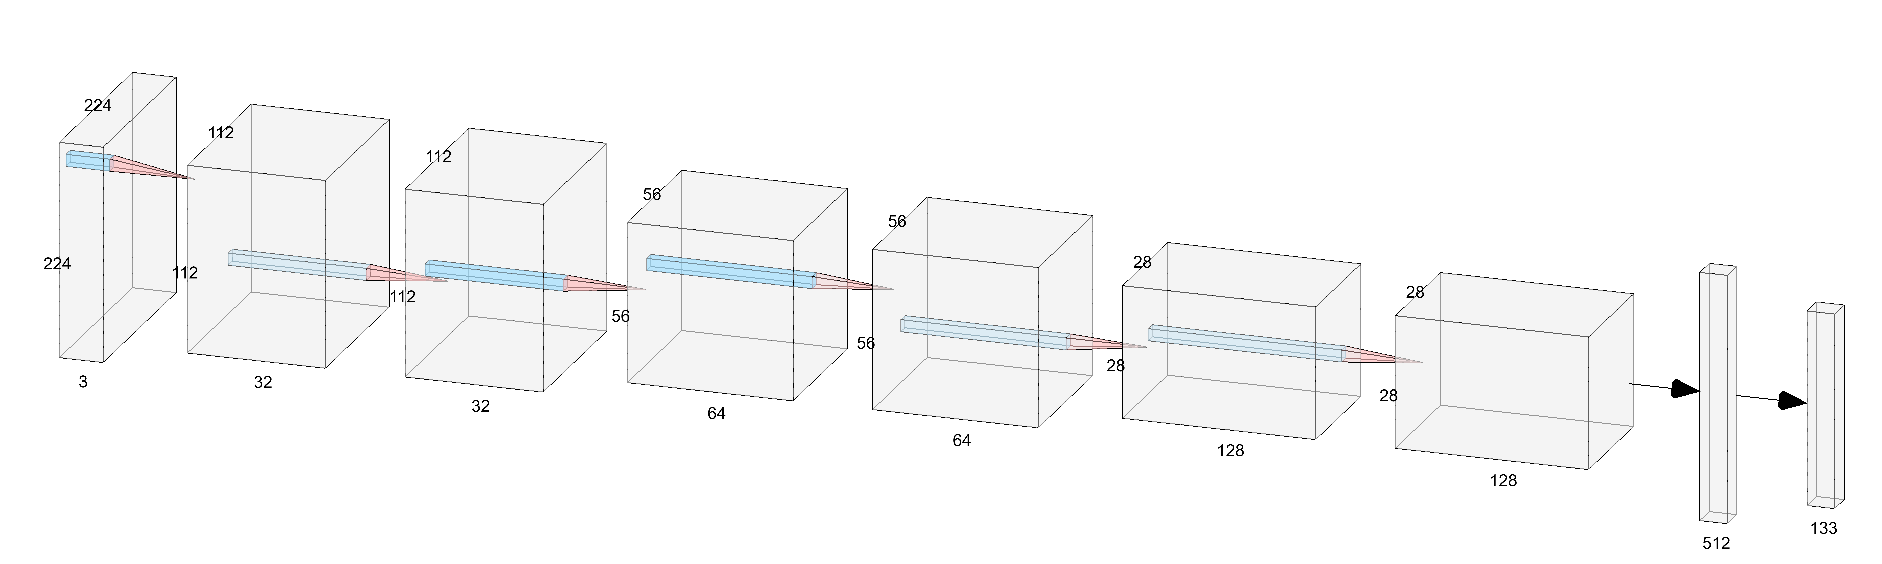

The schematic above was generated using the __[NN SVG tool](http://alexlenail.me/NN-SVG/)__.

### Finding an appropriate learning rate
Before we start we should be careful about the learning rate we choose. Too high and it will never converge. Too low and it will take too long. After a bit of experimentation I found a range that is worth testing. Note that for finding the learning rate we use some data augmentation, otherwise the terrible overfitting (that you will soon see) will prevent us from drawing any conclusions. 

We will soon get to the data augmentation part, but if you're curious about the transforms we applied you can inspect the function **try_learning_rates()** in **misc.py**.

The goal of this part was not to achieve the best possible performance, or to investigate the influence of each augmentation method, but just to select an appropriate learning rate that we might use for the rest of the work.

In [3]:
learning_rates = [1e-4,2.5e-4,5e-4,7.5e-4,1e-3]
file_names = ["lr_1e_4.pt","lr_2_5e_4.pt","lr_5e_4.pt","lr_7_5e_4.pt","lr_1e_3.pt"]

try_learning_rates(learning_rates,file_names,image_folder,75,device)

Trying / loading learning rate 1/5: lr = 0.0001
Trying / loading learning rate 2/5: lr = 0.0003
Trying / loading learning rate 3/5: lr = 0.0005
Trying / loading learning rate 4/5: lr = 0.0008
Trying / loading learning rate 5/5: lr = 0.0010


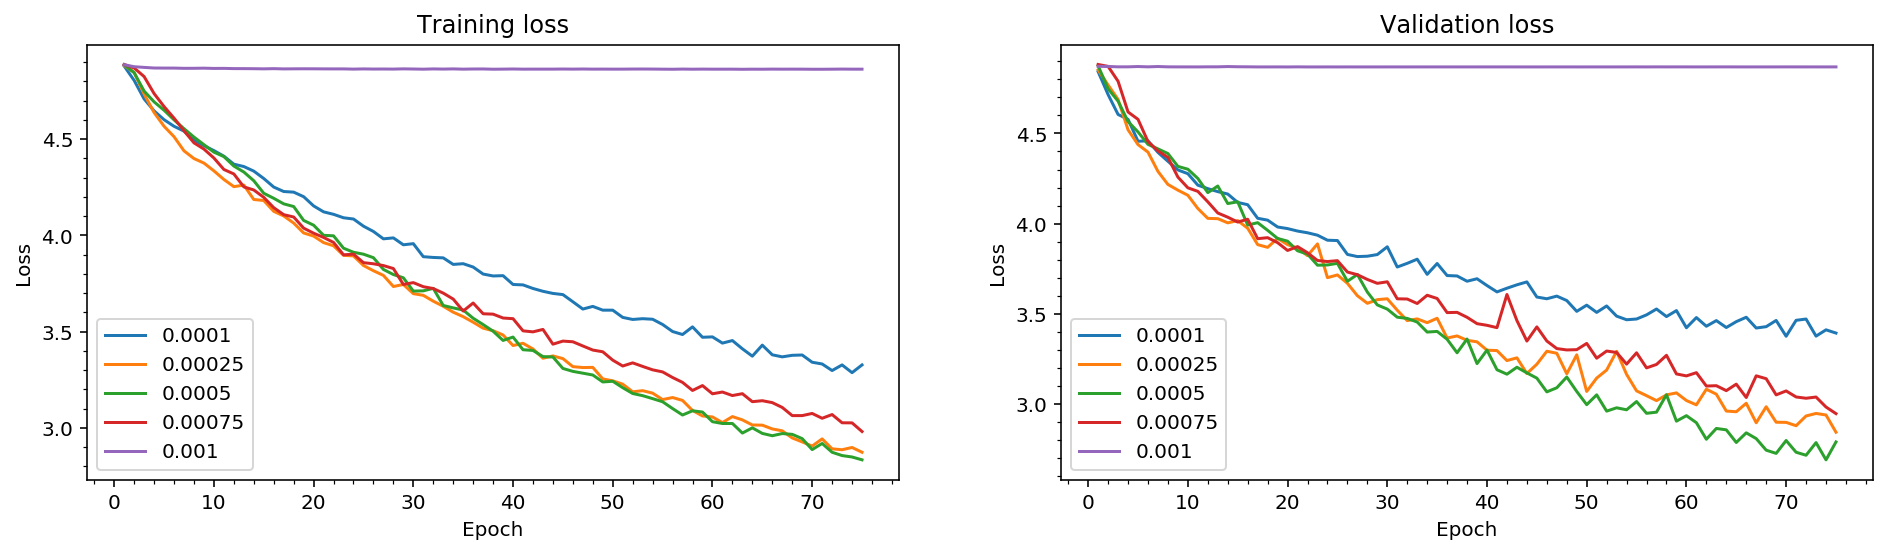

In [4]:
# Show how each learning rate performed
path_list = [f"./learning_rates/lr_1e_4.pt",
            f"./learning_rates/lr_2_5e_4.pt",
            f"./learning_rates/lr_5e_4.pt",
            f"./learning_rates/lr_7_5e_4.pt",
            f"./learning_rates/lr_1e_3.pt"]
model_names = ["Rescaling", "5crop - mean", "5crop - max"]
show_loss_many_models(path_list, model_names = learning_rates)

It looks like the optimum learning rate is 5e-4. It trains as fast as 2.5e-4 but has smaller validation loss as well as less variance in it. It's also interesting that training with 7.5e-4 is slower. Let's use 5e-4 for the rest of our experiments.

In [5]:
learning_rate = 5e-4

In [6]:
# Define the transform. All images must have the same size.
# We don't want to crop only the center and potentially leave the dog's head out of the picture
# So let's simply rescale to a square image for now.
transform_train = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)),  
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, batch_size = batch_size, num_workers = num_workers)

Let's train the model with no data augmentation to see how that works. 

Here we will train the model for only 20 epochs, which will be more than enough to prove a point. 

In [7]:
path_model = f"./trained/model_1_basic_{20}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
# Larger learning rates lead nowhere apparently
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,20,device)

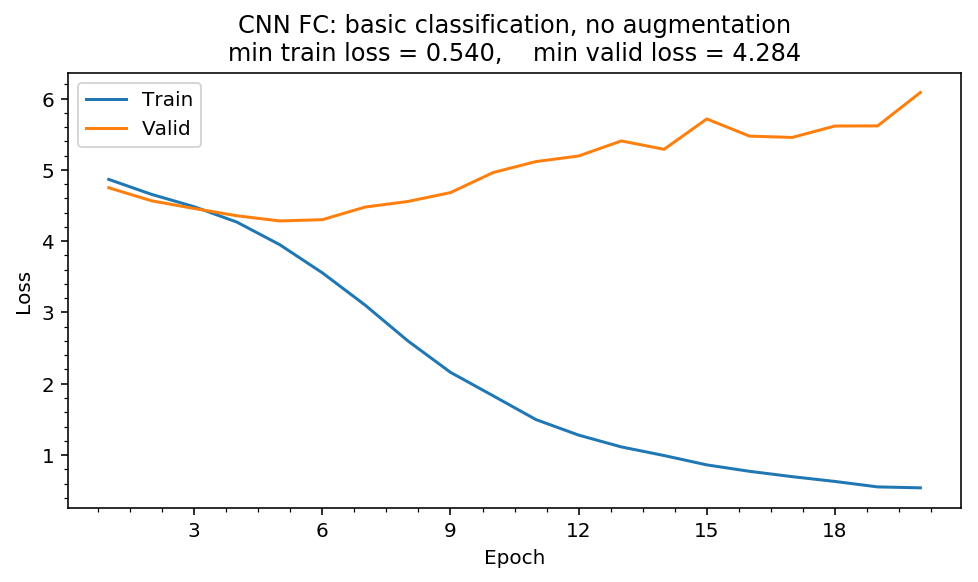

In [8]:
# Show training and validation loss for this model
show_loss_one_model(train_loss, valid_loss, 
                    f"CNN FC: basic classification, no augmentation\n" + 
                    f"min train loss = {min(train_loss):.3f},    min valid loss = {min(valid_loss):.3f}")

And this is why we needed some data augmentation for finding a good learning rate. Without any, our model starts overfitting as soon as the fifth epoch or so. This is mainly due to the small number of training images. On average, there are 50 images per class, with a minimum of 26 for the Norwegian buhund and a maximum of 77 for the Alaskan malamute. I found these numbers using the **get_samples_per_class()** function from **misc.py** but I don't recommend running it here because my implementation for counting samples is very slow.

<a id="step_2"></a>
## Step 2: Image augmentation
### Playing around with transforms
First try each transform separately to get an idea about the parameters. Then combine the transforms using Compose.

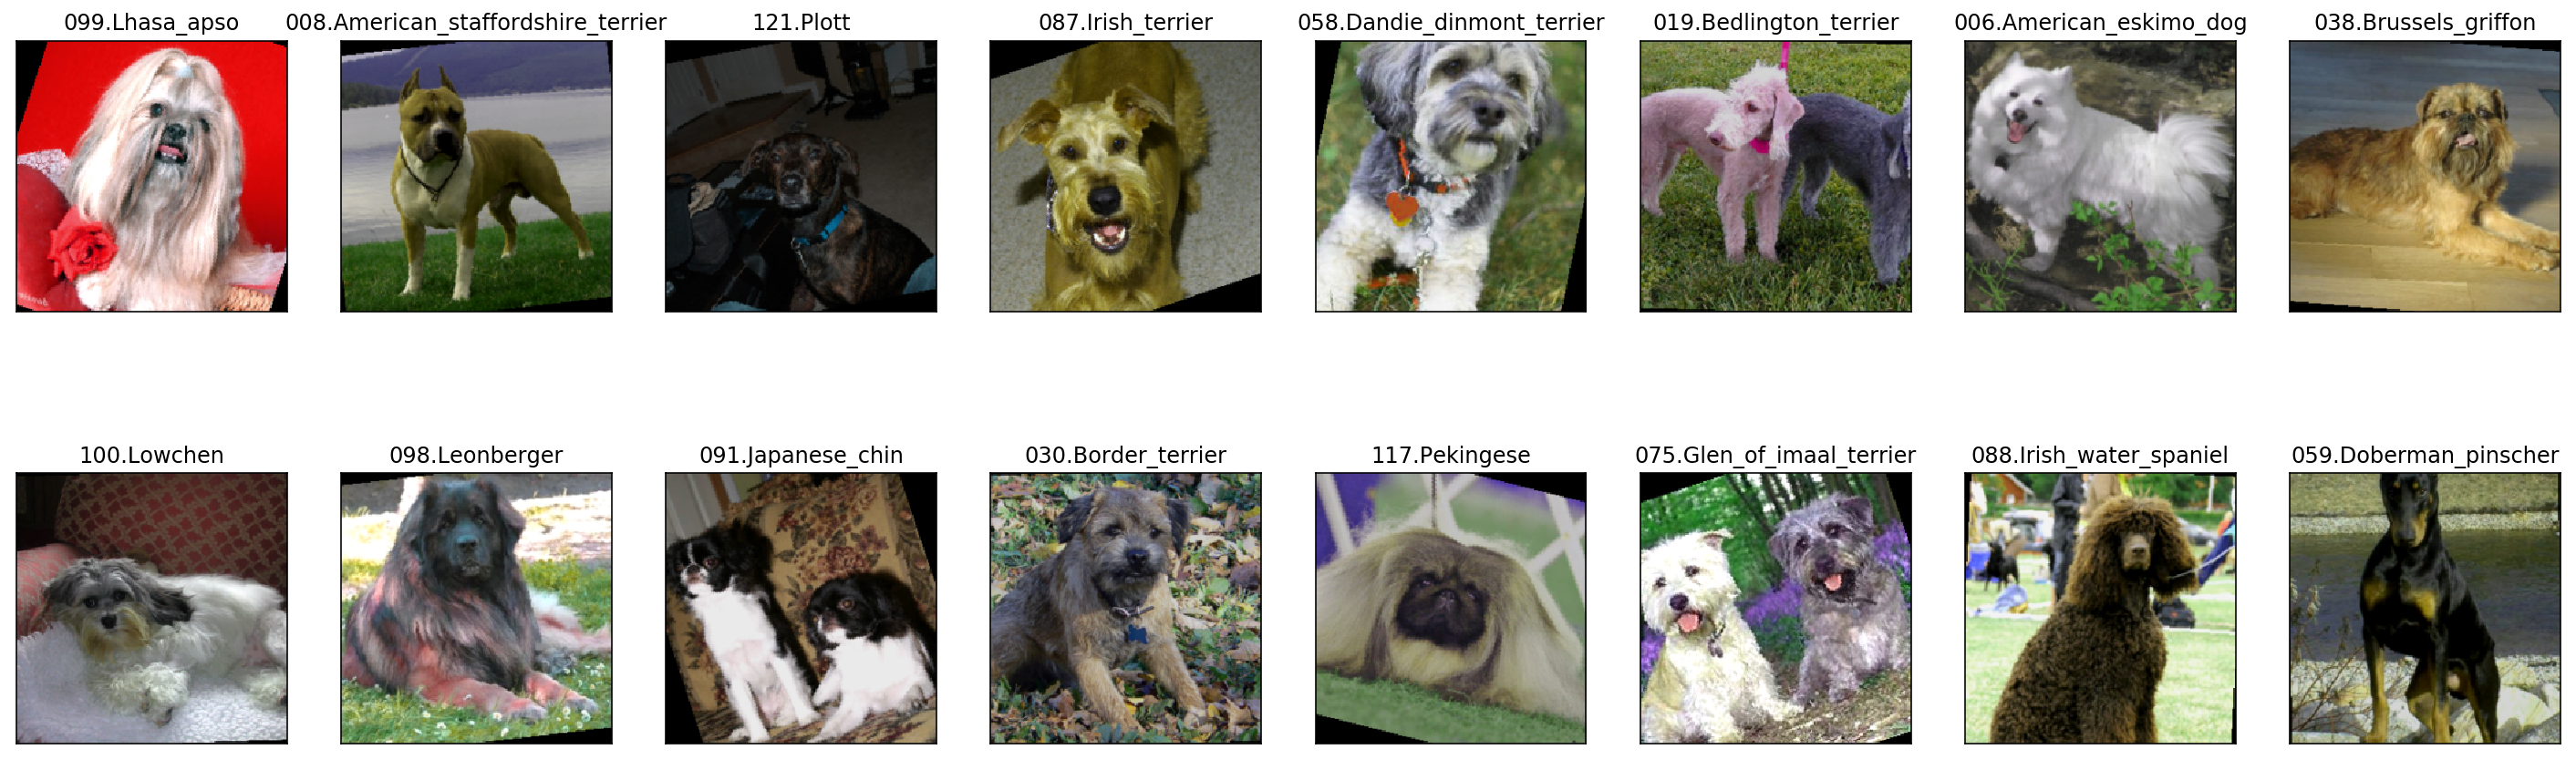

In [9]:
# The transform below is a satisfactory result for me after getting a feel of the parameter effects of each transform
transform = transforms.Compose([
                    transforms.Resize(img_short_side_resize), # resize by keeping the aspect ratio
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),    
                    transforms.RandomRotation(20),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.7,1), ratio=(1,1)),    
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
show_batch(image_folder + "train/", transform = transform, shuffle = True)

##### Thoughts:
- Found out the hard way later that resizing should be first, otherwise during training the CPU will have a hard time keeping up with the GPU while doing the color jitter on full resolution images.
- RandomHorizontalFlip and ColorJitter should clearly be there. The horizontal flip because dogs might come from the left or the right and the color jitter because camera quality and white balance can differ.
- Would the black borders introduced by rotations hurt performance? 
- What about stretching the aspect ratio? That's what we did for finding the learning rate, but is it really the best approach? 
- RandomResizedCrop takes a crop of the image of a size randomly chosen from the scale parameter, and stretches its aspect ratio according to the ratio parameter. There are two aspects here I'd like to investigate:
    - On one hand, if the crop scale is too small the dog's head might be omitted from the picture, which would probably hurt performance. On the other hand the dataset is very small so maybe a small scale would force the network to "look" at other details also and not only at the most obvious patterns. The default min scale is 0.08, while I find a min scale of 0.7 to preserve most dog heads in the picture. Let's see which performs better.
    - What is the influence of stretching the aspect ratio? 
    

### Let's check the influence of image augmentation like this:
- First we deal with the terrible overfitting we saw above. Perhaps some train set augmentation can help.
- Then we see if rescaling the image to another aspect ratio like we did before is a good idea or not. 
- Then add rotation to determine if there's any impact of the black borders for this application.

#### 1. Data augmentation for preventing overfitting
One thing is clear from the first model we trained. It overfits like crazy and dropout is not enough to stop that. There's no point in comparing performances of such underachieving models. So let's see if augmenting the train set can improve things. We could try color jitter and horizontal flip.

Spoiler alert, it's not quite enough. It's not at all enough, the model still overfits quite badly. 

So let's do some random cropping from the rescaled image and keep our test transform the same. So we keep rescaling training images to squares (therefore changing their aspect ratio) and we just add resized (square) crops from those images. Let's also investigate if a small scale is beneficial or not for this dataset.

###### Large crops

In [10]:
transform_train = transforms.Compose([
                    transforms.Resize((img_short_side_resize,img_short_side_resize)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.7,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)),  
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, batch_size = batch_size, num_workers = num_workers)

In [11]:
path_model = f"./trained/model_2_aug_large_crops_rescale_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,n_epochs,device)

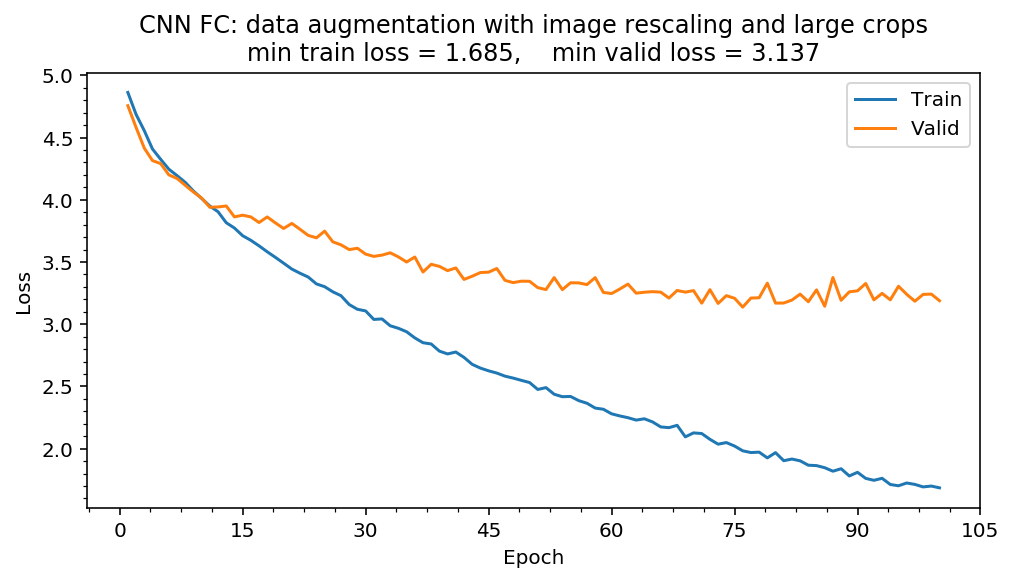

In [12]:
# Show training and validation loss for this model
show_loss_one_model(train_loss, valid_loss, 
                    f"CNN FC: data augmentation with image rescaling and large crops\n" + 
                    f"min train loss = {min(train_loss):.3f},    min valid loss = {min(valid_loss):.3f}")

We see that after epoch 15 or so the validation loss stops decreasing and completely diverges from the training loss. This is not a good sign for our large crops approach. It looks like the dataset is not augmented enough and the model still overfits. Let's see if using small crops works better. 

###### Small crops

In [13]:
transform_train = transforms.Compose([
                    transforms.Resize((img_short_side_resize,img_short_side_resize)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)),  
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, batch_size = batch_size, num_workers = num_workers)

In [14]:
path_model = f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,n_epochs,device)

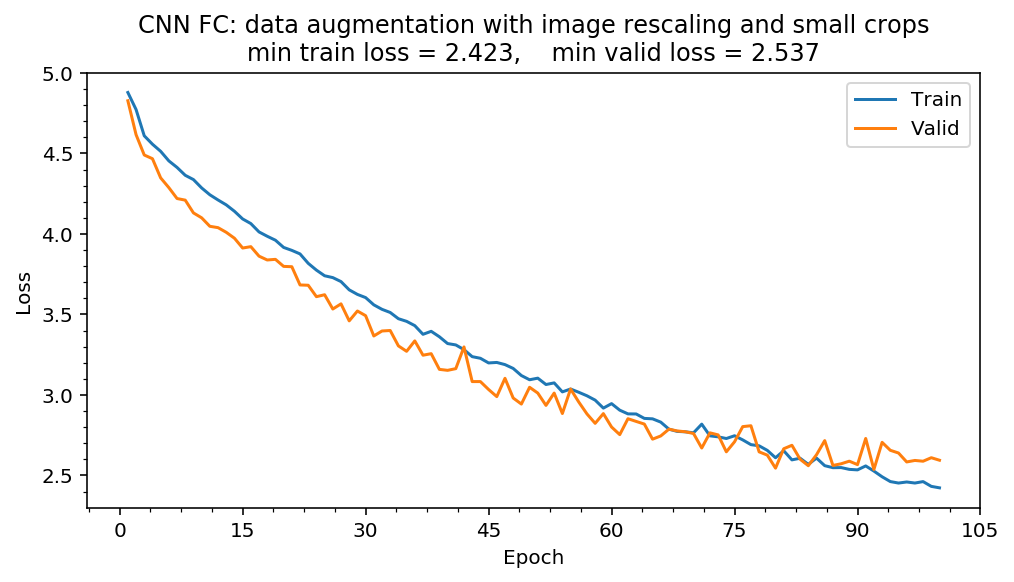

In [15]:
# Show training and validation loss for this model
show_loss_one_model(train_loss, valid_loss, 
                    f"CNN FC: data augmentation with image rescaling and small crops\n" + 
                    f"min train loss = {min(train_loss):.3f},    min valid loss = {min(valid_loss):.3f}")

Wow, now that's something else! Looks like I was completely wrong about the dog's head having to be in the picture. I suppose it figures since I'm not very good at distinguishing dog breeds :) 

Let's see the two approaches side by side.

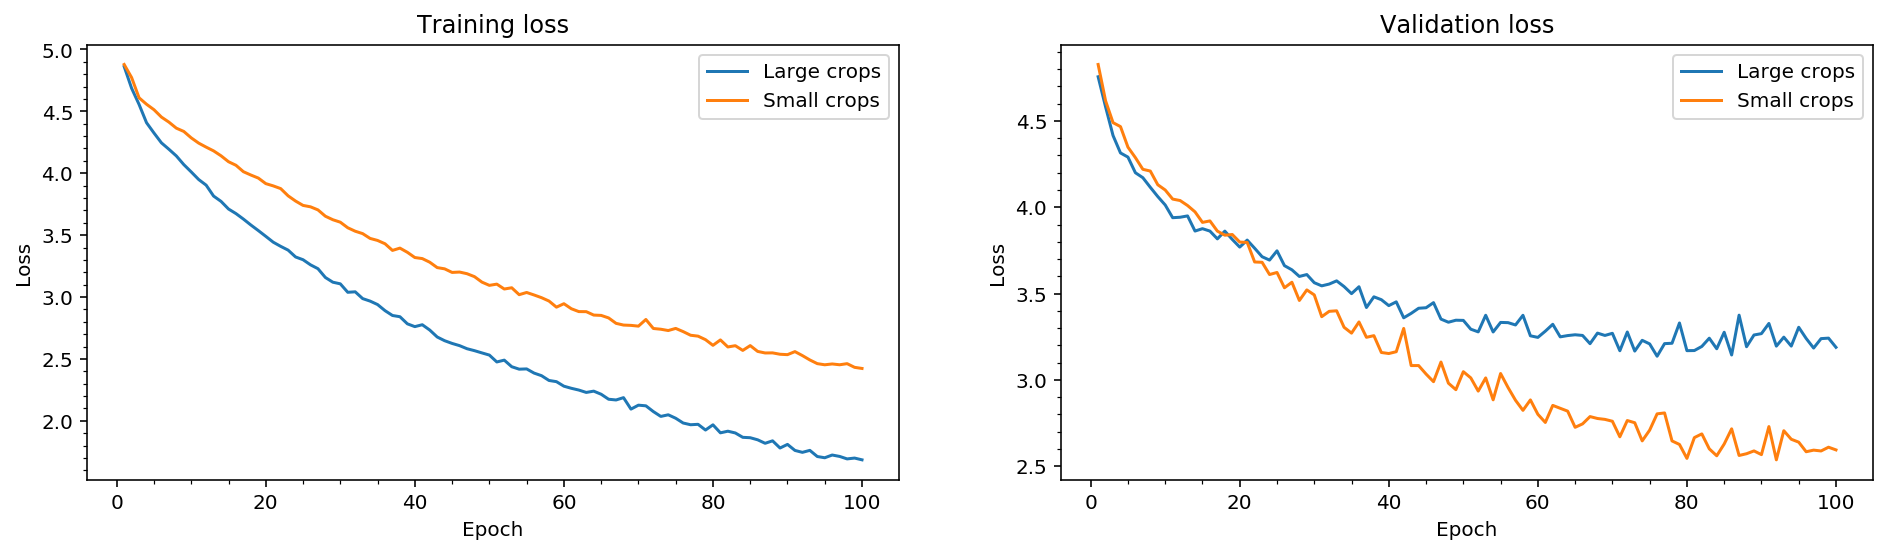

In [16]:
path_list = [f"./trained/model_2_aug_large_crops_rescale_{n_epochs}.pt",
           f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt"]
model_names = ["Large crops", "Small crops"]
show_loss_many_models(path_list, model_names = model_names)

So what I think happened here is that the network learnt to use as much information as possible, and not just obvious hints such as ear and snout shape. Going for potentially very small crops and resizing them probably has another advantage as well: it's basically equivalent to blurring the input, which might make the network more robust to photo quality differences or improper focus. All in all, the small crops approach vastly outperforms the large crops one. This really goes to show that while convolutional nets seem intuitive we should always test the influence of parameters rather than relying solely on our intuition. 

This also shows why training for a large number of epochs (especially with aggressive augmentation) is important: training just 20 epochs or so would have given us the false impression that the large crops approach is better.

#### 2. Image rescaling VS cropping
What is better, changing the aspect ratio and potentially distorting the images or maintaining aspect ratio? Maintaining aspect ratio during training is as simple as passing a single argument to transforms.Resize instead of a tuple. The RandomResizedCrop with a ratio parameter of (1,1) will make sure we extract square crops from our image for training. But how do we maintain aspect ratio at test time?

One way is to use the __[FiveCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.FiveCrop)__ transform, which splits the image into the center crop and the corners, hopefully with a healthy amount of overlap. The validation function needs a bit of tweaking to accommodate the different tensor size, and the results for all five crops are then averaged. An example is found in the __[documentation](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.FiveCrop)__. 

In [17]:
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

Is averaging the output of the five crops really the best approach though? Convolutional networks are based on the philosophy of detecting a pattern, no matter where it is. That's why we use max pooling and that's why all kernels belonging to a slice share weights. We don't want to dillute the "pattern detected" message by averaging it with locations in which the pattern was not detected. Let's then try out two approaches, one in which we take the mean of the five outputs and one in which we take the maximum. 

#### Five crop with mean

In [18]:
path_model = f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Five crop with max

In [19]:
path_model = f"./trained/model_2_aug_small_crops_5crop_max_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "max")

#### Compare both with the rescale approach

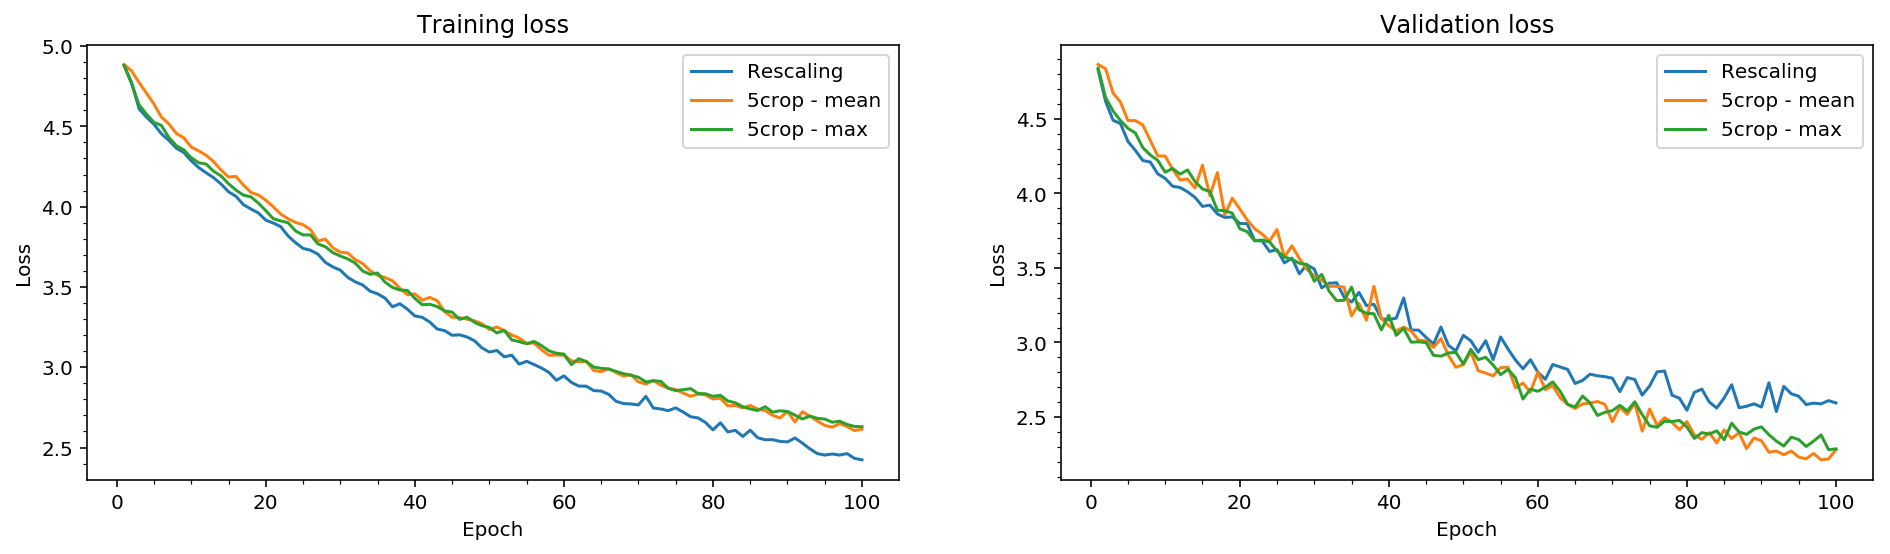

In [20]:
path_list = [f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt",
            f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_2_aug_small_crops_5crop_max_{n_epochs}.pt"]
model_names = ["Rescaling", "5crop - mean", "5crop - max"]
show_loss_many_models(path_list, model_names = model_names)

From the plot above we can see that the validation loss for the rescaling method does seem to plateau from around 60 epochs onward. Furthermore it looks more noisy compared to 5crop, which suggests that 5crop for inference (or maybe test time augmentation in general?) is the way to go. The comparison is not completely fair though: is the improvement due to test time augmentation or keeping the aspect ratio? Let's answer that question by changing the aspect ratio in RandomResizedCrop.

Since there's no difference between the mean and max methods I'll keep the Pytorch recommendation and stick to the mean.

In [21]:
# Add aspect ratio stretching in RandomResizedCrop. PyTorch recommendations were pretty good before, let's try them. 
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(3/4,4/3)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])

data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [22]:
path_model = f"./trained/model_2_aug_rescale_5crop_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Compare with normal rescaling and 5crop without rescaling

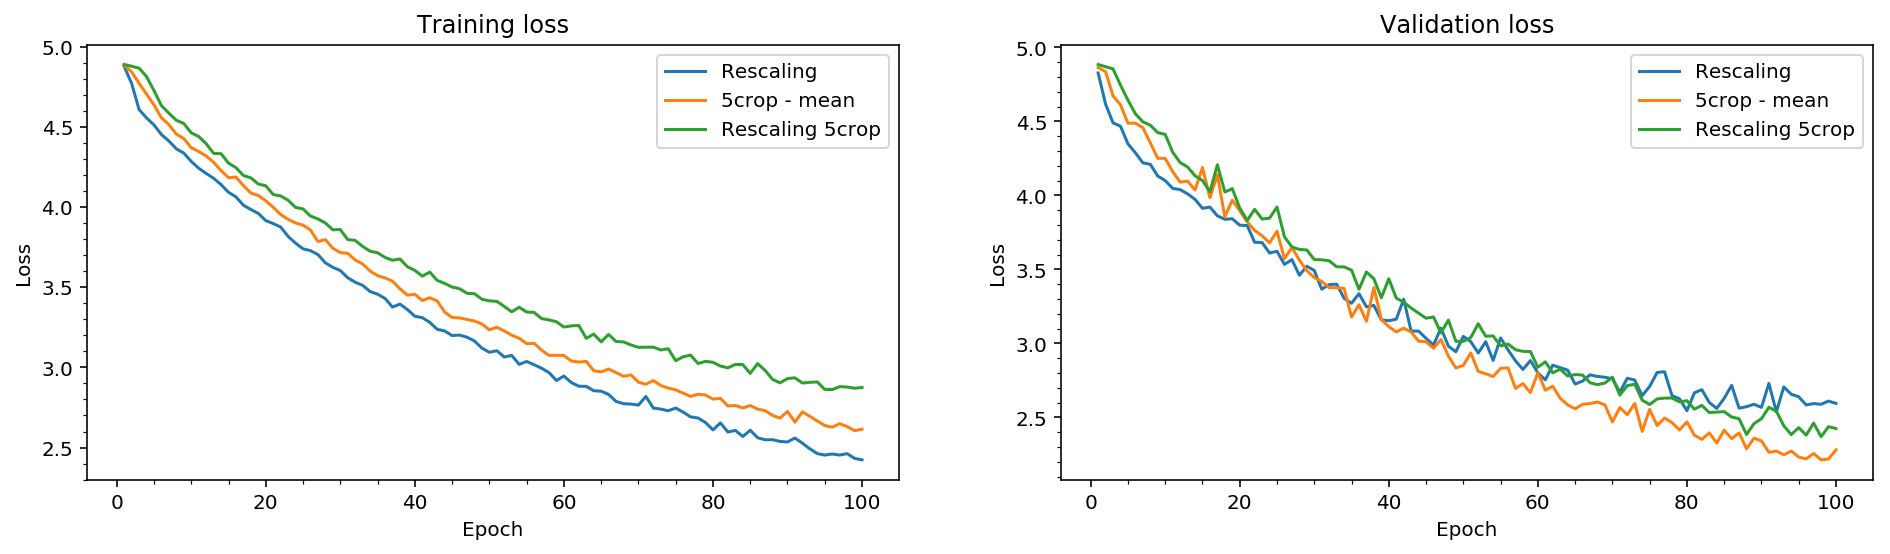

In [23]:
path_list = [f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt",
            f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_2_aug_rescale_5crop_{n_epochs}.pt"]
model_names = ["Rescaling", "5crop - mean", "Rescaling 5crop"]
show_loss_many_models(path_list, model_names = model_names)

It seems that the improvement we saw before mostly came from preserving the aspect ratio. Even with test time augmentation, changing the aspect ratio does not seem beneficial for this dataset. We will therefore preserve the aspect ratio from now on.

#### Introducing rotations

In [24]:
# Add rotation.
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomRotation(20),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])

data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [25]:
path_model = f"./trained/model_2_aug_5crop_rot_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Compare with previous results

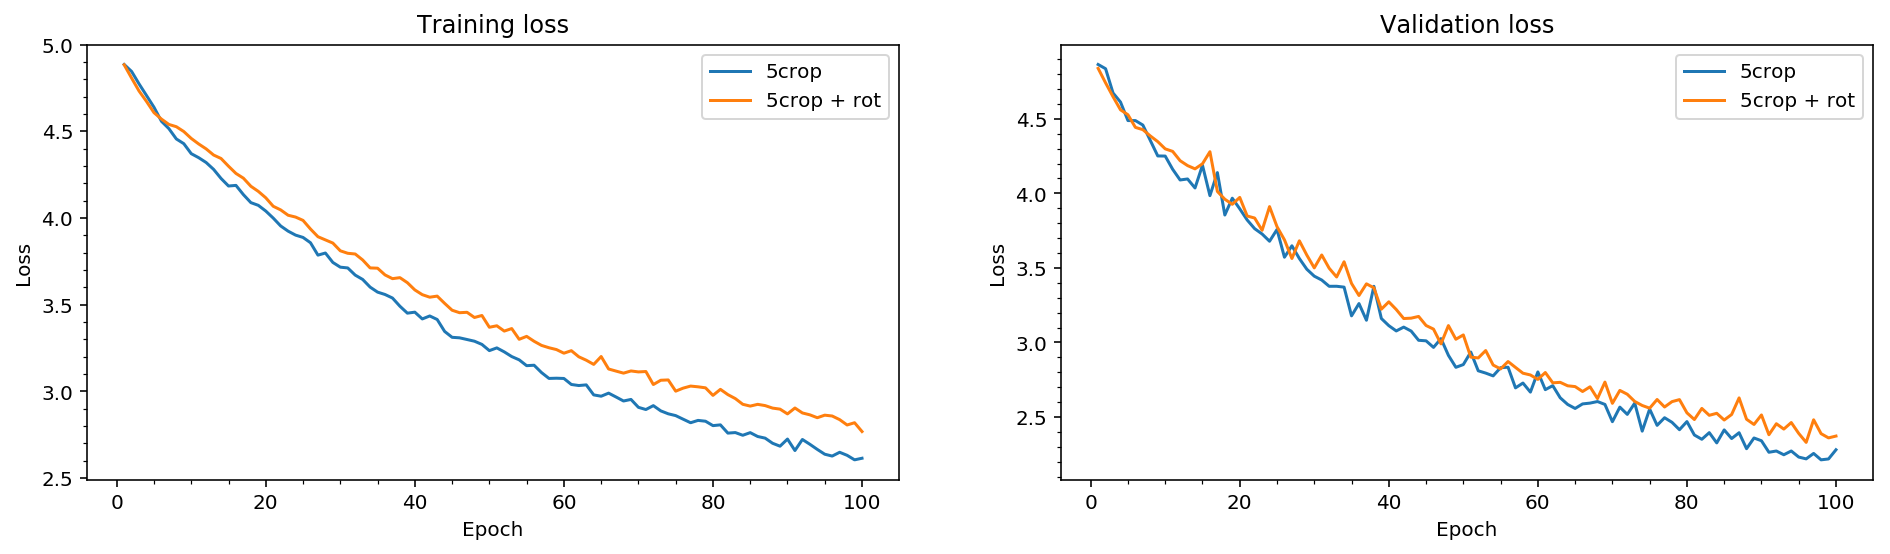

In [26]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_2_aug_5crop_rot_{n_epochs}.pt"]
model_names = ["5crop", "5crop + rot"]
show_loss_many_models(path_list, model_names = model_names)

We see that introducing rotations also makes the model train slower and produces a higher validation loss. We will not use rotations any further.

<a id="step_3"></a>
# Step 3: Adding complexity
### Adding another fully connected layer with dropout
Assuming our convolutional layers are sufficient, one way of making the network more expressive is to introduce another fully connected layer at the end. We will add another layer of 512 neurons. This is implemented in Net_2FC found in misc.py.

In [27]:
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])

data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [28]:
path_model = f"./trained/model_3_2fc_{n_epochs}.pt"
from misc import Net_2FC # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_2FC(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Compare with previous results

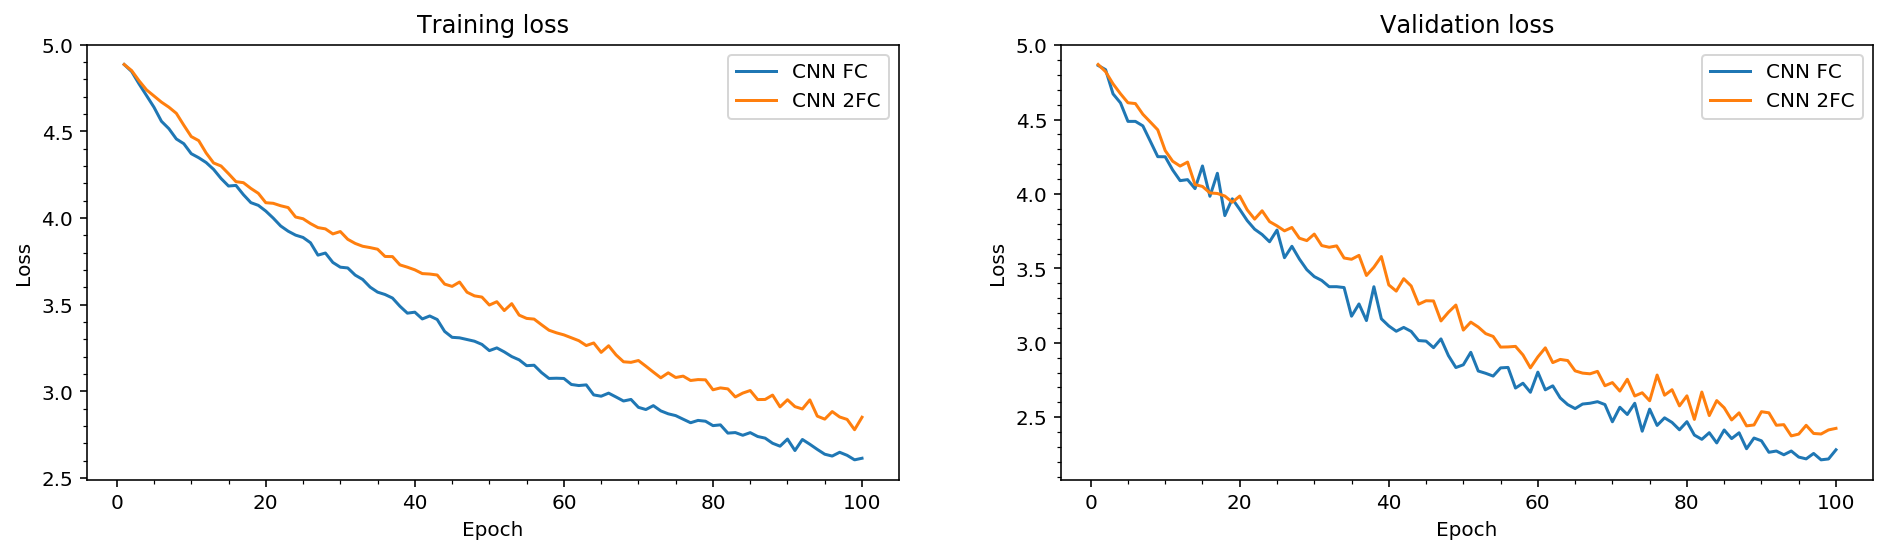

In [29]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_3_2fc_{n_epochs}.pt"]
model_names = ["CNN FC","CNN 2FC"]
show_loss_many_models(path_list, model_names = model_names)

Adding another fully connected layer doesn't seem to improve performance. Let's try going the other way. Instead of increasing complexity, we could try...

<a id="step_4"></a>
# Step 4: Reducing complexity
### Global average pooling
So global average pooling basically means this:
1. Take the average over width and height of your last conv layers (so dimensions 2 and 3).
2. Feed it into a fully connected layer with n_classes neurons. 

Sounds pretty good. We're reducing complexity by a huge factor by eliminating the fully conected layer, since each neuron in the FC layer is connected to each neuron from the conv set! 

My problem though is with the first step. Why take the mean? It feels like it's going against conv net principles of detecting a pattern of interest no matter where it is in the picture. Sure, we have activation functions so we'll take a mean of all the "detections". But is that really the best way? What if we could make it more expressive? 

Let's try a couple of ideas for testing our intuition:
1. **Max**: Take the max instead of the mean. This is more in line with the philosophy of neural nets. The normal max pooling layers are used instead of averaging because in this task we want to know whether a pattern is present or not irrespective of location. Dilluting that information with zeroes or low activations is conceptually not useful. 
2. **Threshold**: Go in-between and take the mean of the largest elements. Maybe a use a threshold equal to mean + 2 standard deviations.
3. **Linear**: Make it more expressive by describing more of the data, such as (mean, standard deviation, minimum, and maximum). Then we feed these into a neuron to come up with a linear transform for each slice. Then to the n_classes output.
4. **Non-linear single**: We add a ReLU to each of those neurons. 
5. **Non-linear multi**: We concatenate the vectors from step 3 from all slices and use that as input to a small fully connected network. There will still be a considerable decrease in the number of parameters. 
I think that the normal way (i.e. fully-connected) of flattening all filters and feeding that to MLPs is wrong. Each hidden neuron would then be connected to each activation in all filters, irrespective of spatial location. What the neuron really wants is a large input that basically says "pattern detected". But when it has thousands of useful inputs, how can it weigh them? How would we weigh them? Maybe assign more weight to the ones in the center? That defeats the purpose of our task of detecting a pattern wherever it might be. Would we give equal weight to all? It certainly seems like a complicated problem and a simple solution is to create location-invariant features that describe each slice and use those as input to a hidden layer and then output. MLPs are great for tabular data, not so much for our task. That's why they work great on MNIST but if you "augment" your input with some translation they become useless. Let's help them out then. 

The problem is that for steps 3 and 4 we would need to either write a custom module for specifying connections or have depth_3 tiny linear layers with 4 inputs and one output. So let's skip steps 3 and 4.

First let's compare the often used average to the max and threshold methods. Note that we're not using any dropout anymore, since our model is much less complex and the risk of overfitting is reduced.

In [30]:
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [31]:
path_model = f"./trained/model_3_pooling_mean_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "mean", p_dropout = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

C:\Users\Mircea\Anaconda3\envs\dl\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'misc.Net_Pool' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [32]:
path_model = f"./trained/model_3_pooling_max_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "max", p_dropout = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

In [33]:
path_model = f"./trained/model_3_pooling_thresh_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "thresh", p_dropout = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

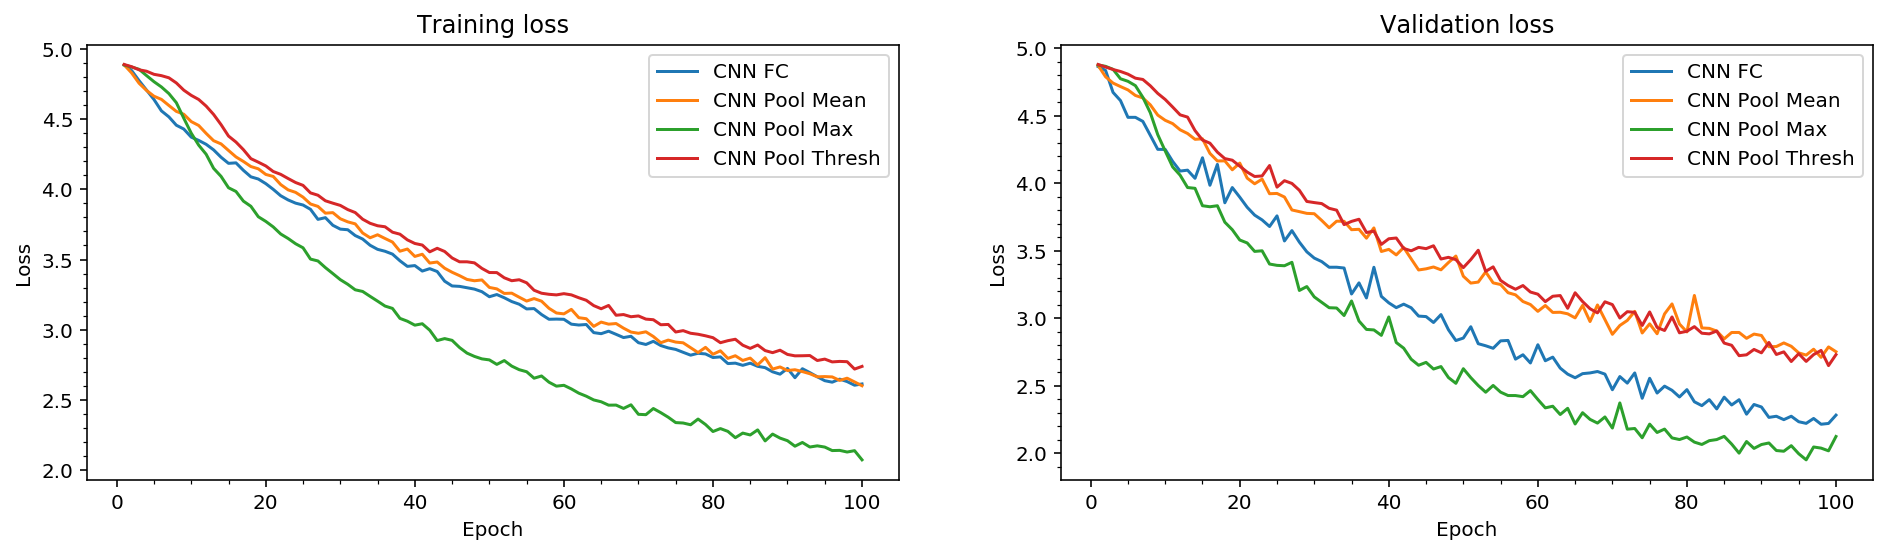

In [34]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_mean_{n_epochs}.pt",
            f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_3_pooling_thresh_{n_epochs}.pt"]
model_names = ["CNN FC","CNN Pool Mean","CNN Pool Max","CNN Pool Thresh"]
show_loss_many_models(path_list, model_names = model_names)



The max is apparently much better. Why do the popular architectures use the mean then? 

Let's now test the non-linear multi method. For each slice in the final convolutional layer, we calculate the mean, the standard deviation, the minimum and the maximum values. We concatenate all of these into a vector and feed it to a fully connected layer with n_classes neurons. For the sake of completeness, we also test a network with two FC layers of n_classes neurons each. More details about the architecture can be gleamed from inspecting **Net_Pool** in **misc.py**.

In [35]:
path_model = f"./trained/model_3_pooling_nonlin_multi_1_layer_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "non-linear multi", extra_layer = False, p_dropout = 0,
                 p_dropout_pool = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

In [36]:
path_model = f"./trained/model_3_pooling_nonlin_multi_2_layers_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "non-linear multi", extra_layer = True, p_dropout = 0,
                 p_dropout_pool = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

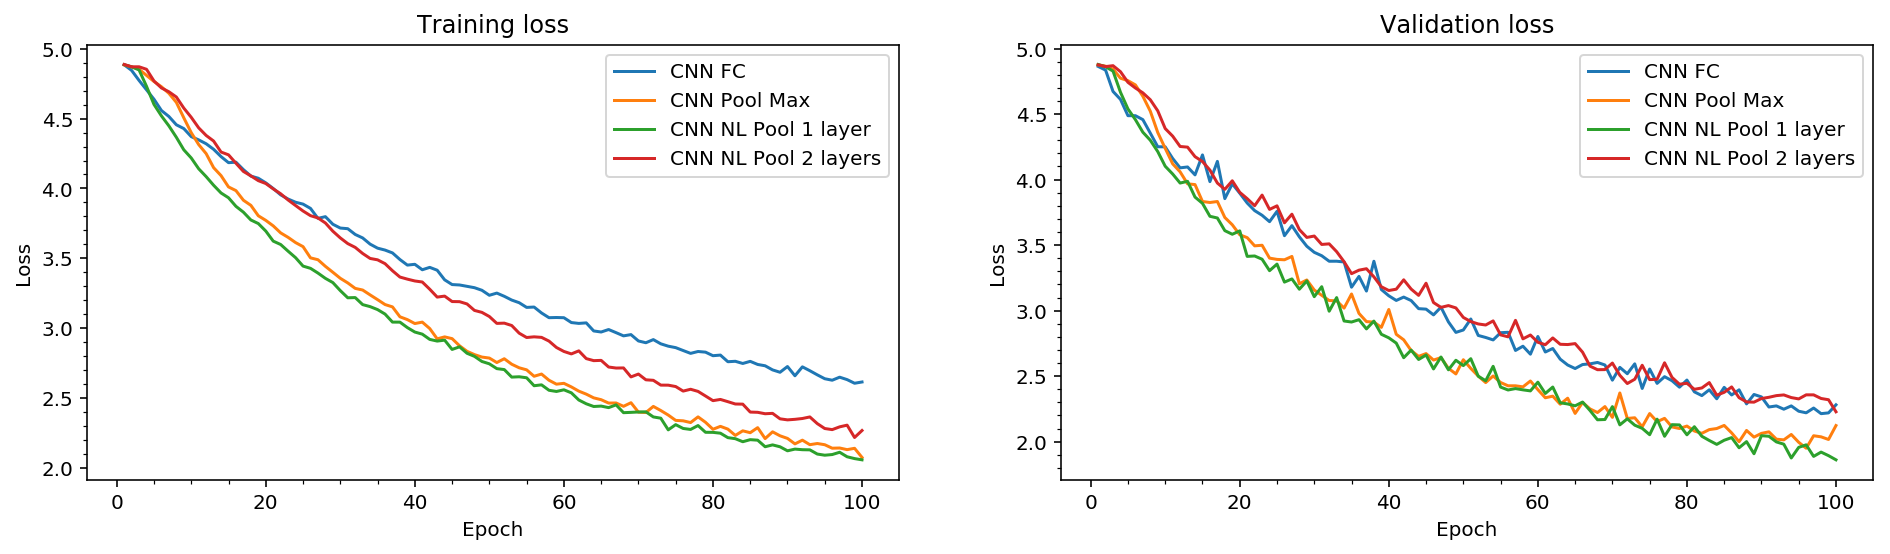

In [37]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_3_pooling_nonlin_multi_1_layer_{n_epochs}.pt",
            f"./trained/model_3_pooling_nonlin_multi_2_layers_{n_epochs}.pt"]
model_names = ["CNN FC","CNN Pool Max","CNN NL Pool 1 layer","CNN NL Pool 2 layers"]
show_loss_many_models(path_list, model_names = model_names)



Adding more complexity to the global pooling does not seem to improve performance. The max seems to be the best way to go so far and is the model we will continue with.

<a id="step_5"></a>
# Step 5: Weight initialization
So far the weights were initialized randomly by PyTorch from a uniform distribution. Let's try the Kaiming initialization, which is designed for our non-linear activations. More details in __[the paper](https://arxiv.org/abs/1502.01852)__ and implementation details in the __[docs](https://pytorch.org/docs/stable/nn.html#torch.nn.init.kaiming_normal_)__.

In [38]:
path_model = f"./trained/model_4_weight_init_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "max", extra_layer = False, p_dropout = 0,
                 p_dropout_pool = 0, img_input_size = img_input_size, weight_init = True)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

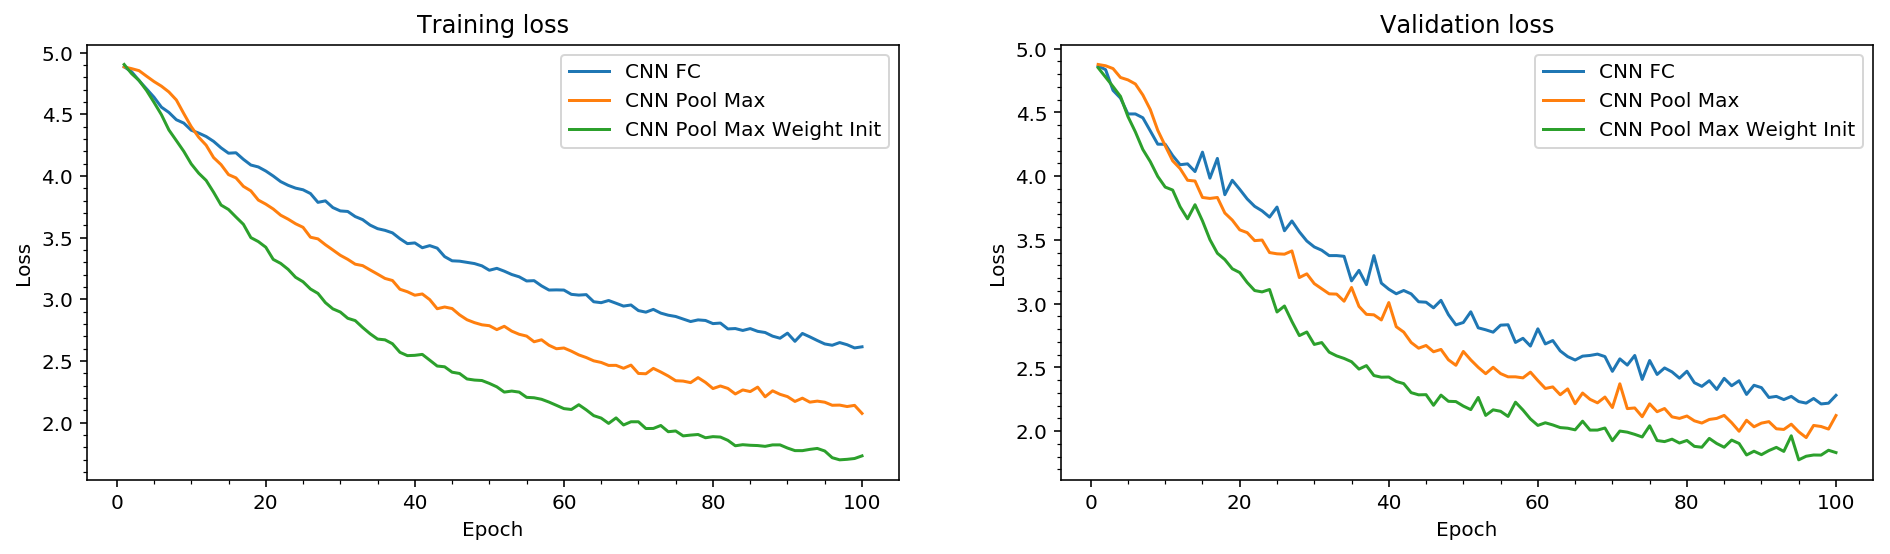

In [39]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt"]
model_names = ["CNN FC","CNN Pool Max","CNN Pool Max Weight Init"]
show_loss_many_models(path_list, model_names = model_names)

Weight initialization gives a big performance boost to our network. Not only does it achieve a lower validation loss, it also trains considerably faster.

<a id="step_6"></a>
# Step 6: Batch normalization
__[Batch normalization](https://arxiv.org/abs/1502.03167)__ is a powerful technique that helps the network learn faster. Batch normalization is similar to input normalization, with two differences: 
- Instead of normalizing (only) the input to the whole network, we also normalize the input to each slice of the convolutional layer. 
- Rather than a z-score transformation to a mean of 0 and standard deviation of 1, we learn parameters alpha and beta that control the mean and the scale of our normalization. We learn a set of (alpha, beta) parameters for each slice. 

Let's see the effect batch normalization has on performance.

In [40]:
path_model = f"./trained/model_5_bn_{n_epochs}.pt"
from misc import Net_BN # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_BN(n_classes, depth_1 = depth_1)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

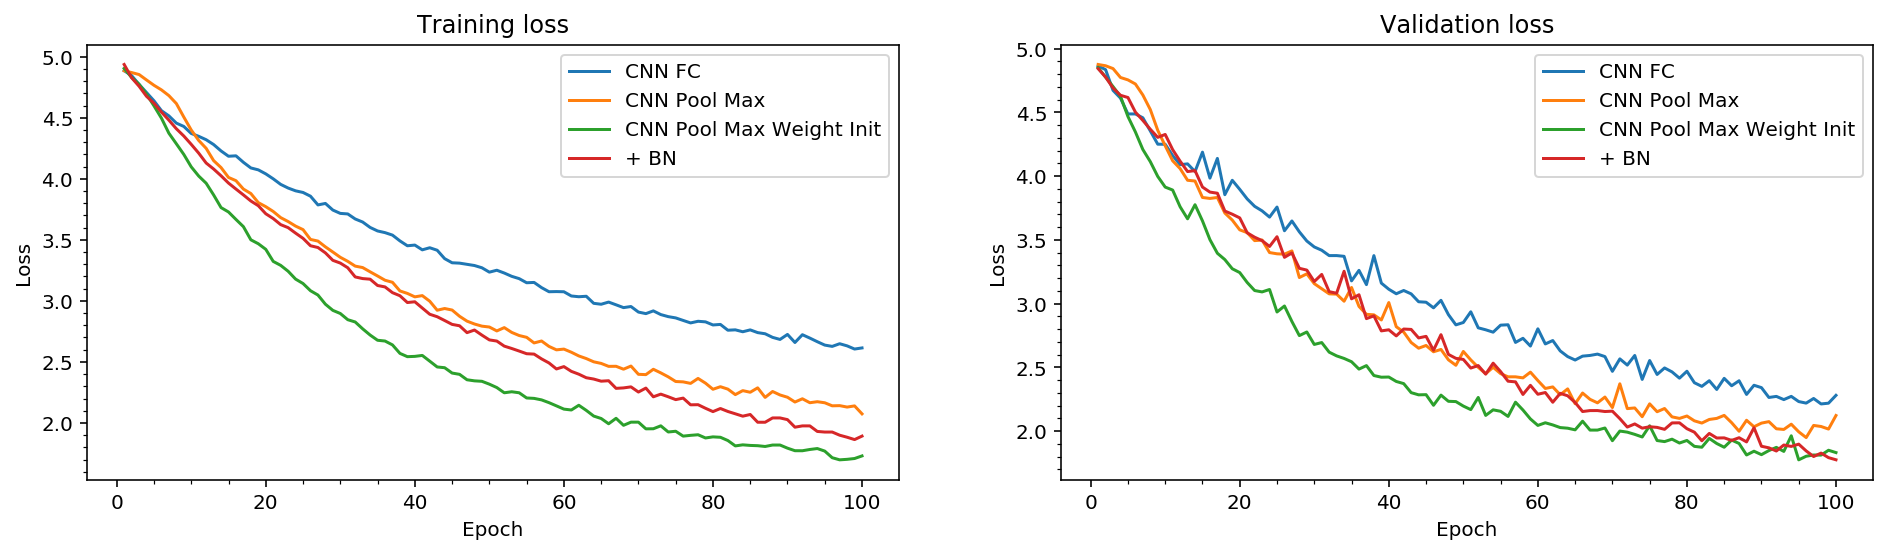

In [41]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt",
            f"./trained/model_5_bn_{n_epochs}.pt"]
model_names = ["CNN FC","CNN Pool Max","CNN Pool Max Weight Init","+ BN"]
show_loss_many_models(path_list, model_names = model_names)



What we see above is that adding batch normalization makes the validation loss decrease more linearly, and likely plateau after a larger number of epochs. Training more is one option, but the biggest advantage of batch norm is that larger learning rates can be used. The authors of the original __[paper](https://arxiv.org/abs/1502.03167)__ managed to increase the learning rate 30 times without ill effects on performance. Below we therefore test 9 different learning rates, from our initial 5e-4 to one approximately 30 times higher. 

There is a catch though. Having too large of a learning rate in the later parts of training can make the optimizer miss the minimum completely and even diverge. We therefore implement a __[learning rate scheduler](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)__ that decreases the learning rate by a factor of 10 if the validation loss does not decrease after a maximum of 10 epochs. 

In [42]:
learning_rates = learning_rate * np.logspace(0,1.5,9)
learning_rate_strings = []
path_list = []
for i in range(len(learning_rates)):
    path_list.append(f"./learning_rates/bn_lr_{learning_rates[i]:.4f}.pt")
    learning_rate_strings.append(f"{learning_rates[i]:.4f}")
try_learning_rates_bn(learning_rates,path_list,image_folder,100,device)

Trying learning rate 1/9: lr = 0.0005
Trying learning rate 2/9: lr = 0.0008
Trying learning rate 3/9: lr = 0.0012
Trying learning rate 4/9: lr = 0.0018
Trying learning rate 5/9: lr = 0.0028
Trying learning rate 6/9: lr = 0.0043
Trying learning rate 7/9: lr = 0.0067
Trying learning rate 8/9: lr = 0.0103
Trying learning rate 9/9: lr = 0.0158


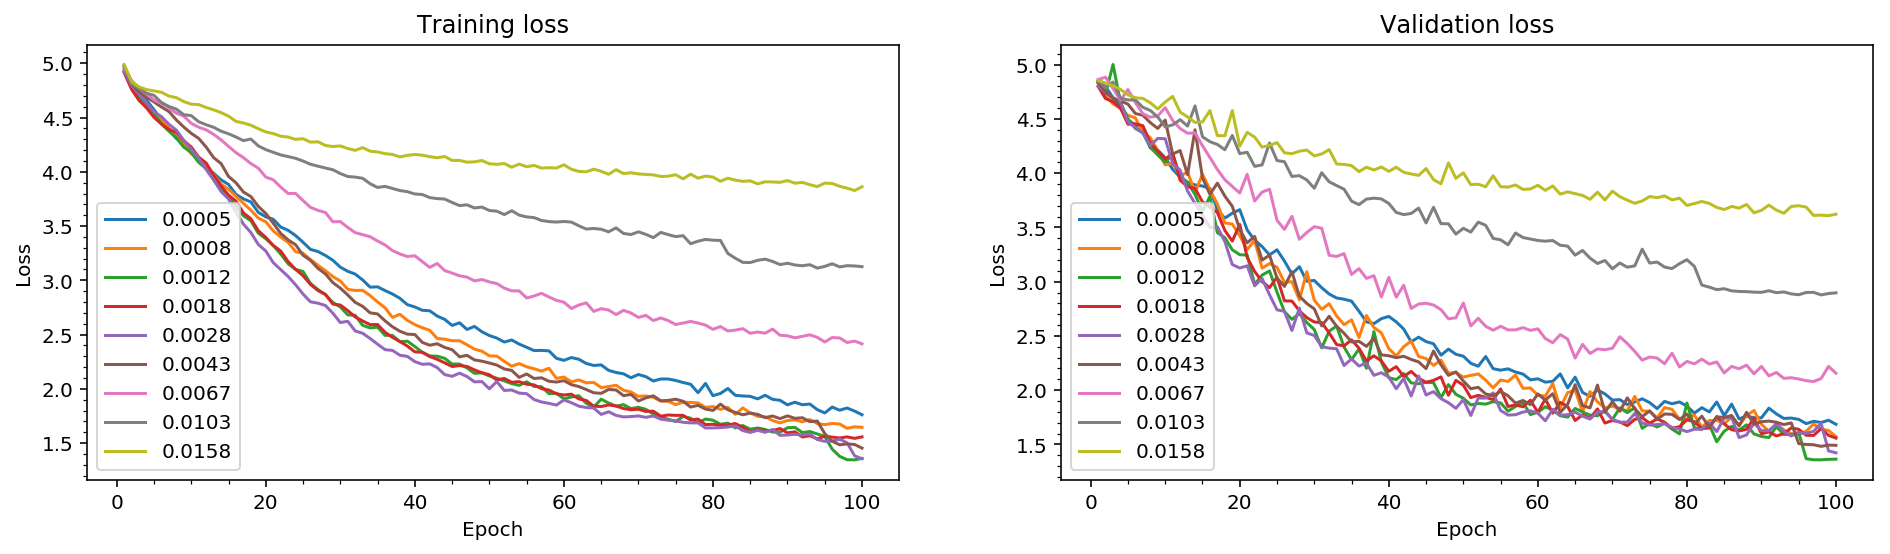

In [43]:
# Show how each learning rate performed
show_loss_many_models(path_list, model_names = learning_rate_strings)

The learning rate of 0.0012 performed best. We can clearly see the learning rate scheduler reducing the learning rate around epoch 94. Let's copy the file "./learning_rates/bn_lr_0.0012.pt" to "./trained/", rename it to "model_5_bn_new_lr_100.pt", and compare this performance to our previous approaches.

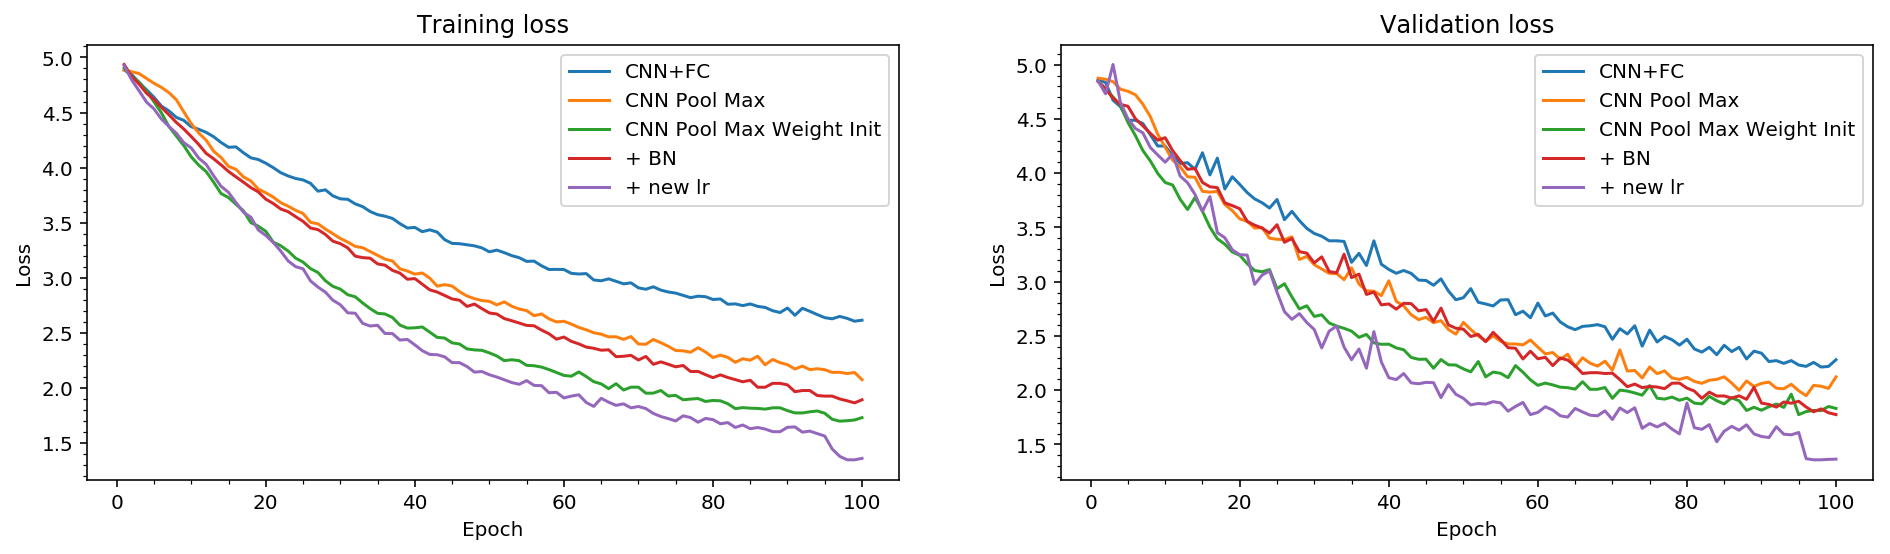

In [44]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt",
            f"./trained/model_5_bn_{n_epochs}.pt",
            f"./trained/model_5_bn_new_lr_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Max","CNN Pool Max Weight Init","+ BN","+ new lr"]
show_loss_many_models(path_list, model_names = model_names)



Changing the learning rate made for a significant improvement, especially after the learning rate scheduler kicked in. We've come a long way from the first approach. There is one last thing that we could try...

In [45]:
learning_rate = learning_rates[2]

<a id="step_7"></a>
# Step 7: Residual connections
__[Residual networks](https://arxiv.org/abs/1512.03385)__ are an important stepping stone in the continued progress of convolutional nets. They arose from the need to answer a simple question: why do very deep networks perform worse than shallower ones? The authors noted that this decreased performance was not due to overfitting, since both training **and** validation loss were higher for the very deep networks. The insightful thought experiment that the authors proposed was that, after all, deeper models could simply learn the identity function and perform as well as their shallower counterparts if deeper features were not necessary. Was this true? To test it, they used connections that skipped certain conv layers and simply added that input to the output of the last layer skipped. To compensate for potentially different depths (number of channels) they either used zero padding or 1x1 convolutions. 

Let's see if residual connections might help our rather shallow network. In **Net_BN_Res** we introduce residual connections between the max pool output of conv set 1 and the ReLU of conv set 2, and between the max pool output of conv set 2 and the ReLU of conv set 3. We use 1x1 convolutions for changing the depth. 

In [46]:
path_model = f"./trained/model_6_res_{n_epochs}.pt"
from misc import Net_BN_Res # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_BN_Res(n_classes, depth_1 = depth_1)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean", do_lr_scheduling = True)

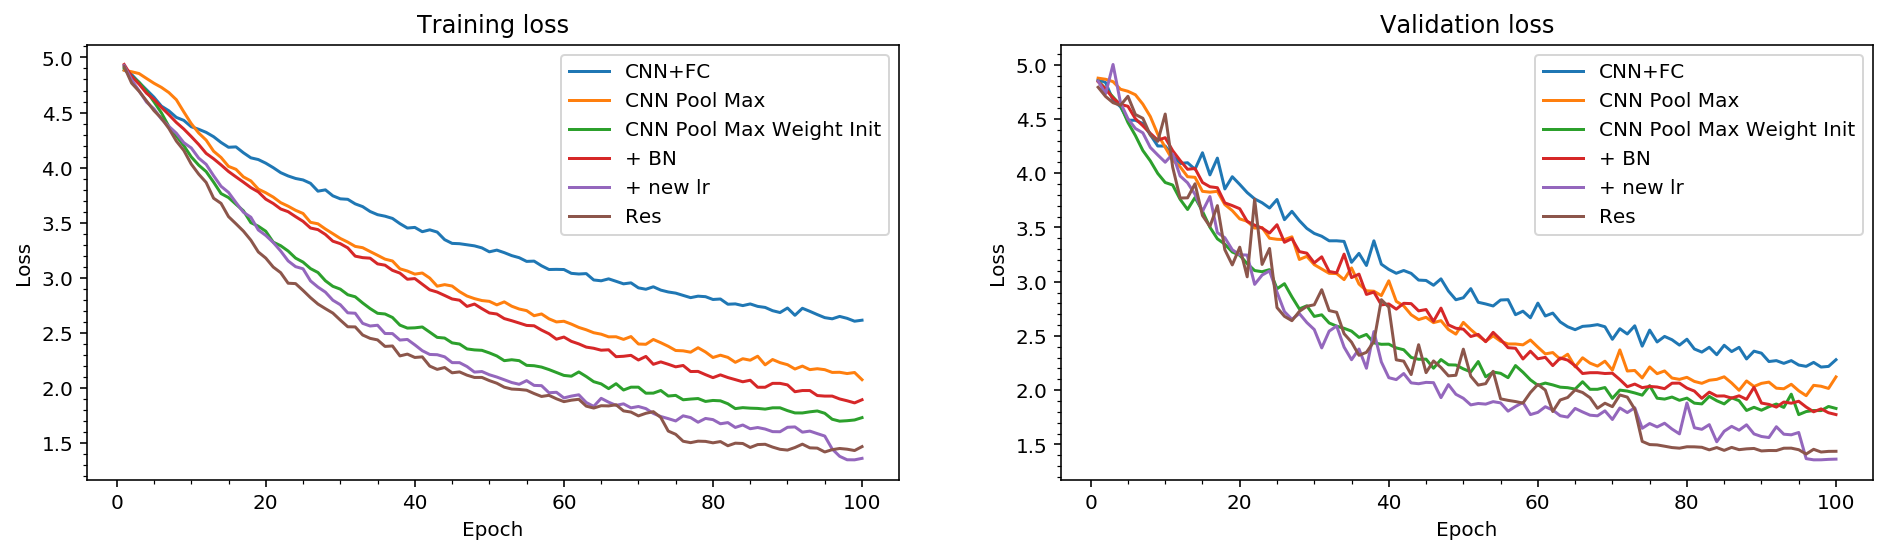

In [47]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt",
            f"./trained/model_5_bn_{n_epochs}.pt",
            f"./trained/model_5_bn_new_lr_{n_epochs}.pt",
            f"./trained/model_6_res_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Max","CNN Pool Max Weight Init","+ BN","+ new lr","Res"]
show_loss_many_models(path_list, model_names = model_names)



In our case the residual connection doesn't seem to help. Even more, the validation loss of the residual network is noisier, possibly indicating less generalization ability. For testing, we will therefore use the following model with weight initialization, batch normalization, global max pooling, and the new learning rate.

<a id="step_8"></a>
# Step 8: Testing

In [48]:
# Load the best model so far
path_model = f"./trained/model_5_bn_new_lr_{n_epochs}.pt"
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean", do_lr_scheduling = True)

In [49]:
test(loaders, model, nn.CrossEntropyLoss(), device)

Test Loss: 1.433812


Test Accuracy: 61% (514/836)


Our test loss is similar to our validation loss, which means the model generalizes well. The test accuracy of 61% is pretty good considering that random chance is less than 1%!

<a id="step_9"></a>
# Conclusions

The main takeaway message here is that data augmentation is mandatory when dealing with small datasets. With only about 50 images per class available for training, our network was overfitting badly. The most important data augmentation step that we took was using small resized crops instead of the original training images or even large crops. This probably forced the network to learn more general patterns rather than focusing on the most obvious ones. 

It was interesting to see that changing the aspect ratio and introducing rotations actually decreased performance. This conclusion is not entirely fair however, since more data augmentation means slower training, and we stopped training after a hard limit of 100 epochs.

As expected, adding complexity in the form of an additional fully connected layer did not improve performance. Many modern architectures replaced the fully connected layers at the end with global average pooling. This did not work very well in our case however, with the global average pooling network performing significantly worse than the fully connected one. While this could have been a sign of insufficient depth at the final convolutional layer, an alternative explanation was that the mean might not be the best choice for global pooling. The philosophy behind our architecture is to detect a relevant pattern wherever it is in the image. That is why we use max pooling between conv layers and that is why each slice in a conv layer shares weights for all spatial locations. Taking the mean of all those locations dillutes any potential activations. Indeed, replacing the global average pooling with global max pooling significantly improved performance. 

While weight initialization and batch normalization provided the boosts that were expected, it was surprising to see the unstable behavior of the residual variant of our network. This aspect certainly deserves more investigation.